In [1]:
import sys
import cvxpy as cp
import mosek
import numpy as np
from itertools import permutations
from math import sqrt,log,factorial,floor
import random 
import time
#from sympy import Matrix
import seaborn as sns
import pandas as pd

In [2]:
def prefer(loci,locj): 
    # returns 1/2 if both candidates are preferred equally.
    # returns 1 if c_i is preferred than c_j and 0 otherwise.
    if loci==locj:
        val=1/2
    else:
        val=int(loci<locj)
    return val

def prefermatrix(rank):
    # S(t): returns the preference matrix for a given ordering.
    loc=[rank.index(i) for i in candidate]
    a=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                a[i,j]= prefer(loc[i],loc[j])
    return a

def FrobeniusNorm(a):
    norm=0
    (b,c)=a.shape
    for i in range(b):
        for j in range(c):
            norm+=(a[i,j])**2
    return sqrt(norm)

def entropy(xx):
    ent=0
    negative=0
    zero=0
    for i in range(T):
        if xx[i]<0:
            negative+=1
            continue
        if xx[i]==0:
            zero+=1
            continue
        ent-=xx[i]*log(xx[i])
        
    print('the number of negative values: ',negative,'; the number of 0: ',zero)
    return ent

def matrix2vector(m):
    n=m.shape[0]
    Aj=np.zeros((int(n*(n-1)/2),1))
    index=0
    for i in range(n):
        for j in range(i):
            #f i < j:
            Aj[index,0]=m[i,j]
            index+=1
    return Aj

def matrix2vector_long(m):
    n=m.shape[0]
    Aj=np.zeros((int(n*(n-1)),1))
    index=0
    for i in range(n):
        for j in range(n):
            if i != j:
                #print(i,j)
                Aj[index,0]=m[i,j]
                index+=1
    return Aj

def assess(xx):
    outcome=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i < j:
                outcome[i,j]=sum(theoretical[t][i,j]*xx[t] for t in range(T))
                outcome[j,i]=1-outcome[i,j]
    #print('The original matrix is:\n',empirical)        
    #print('The output matrix is:\n',outcome)
    #print('The entropy of u is:',entropy(xx))
    #print('The Frobenius Norm of the difference is:',FrobeniusNorm(empirical-outcome))
    return FrobeniusNorm(empirical-outcome), entropy(xx)

def report(xx,u,status,runtime):
    """
    yy=xx[u:u+T]
    yy.sort(reverse=True)
    print('Sorted probabilities:\n',yy)
    """
    xxx=np.zeros((T))
    count=0
    for t in range(T):
        if xx[t] > 10**(-5):
            xxx[t]=xx[t]
            count+=1
    #print('the number of rank is:',count)
    print('the status is:',status)
    print('the runtime is:',runtime)
    print('the size of the orderings set is',T)

def msk_relent(task, t, x, y):
    v = msk_newvar(task, 1)
    c = msk_newcon(task, 1)
    task.putaij(c, v, 1.0)
    task.putaij(c, t, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 0.0, 0.0)
    task.appendcone(mosek.conetype.pexp, 0.0, [y, x, v])

def msk_newvar(task, num):  # free
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fr, -inf, inf)
    return v

def msk_newvar_fx(task, num, val):  # fixed
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fx, val, val)
    return v

def msk_newcon(task, num):
    c = task.getnumcon()
    task.appendcons(num)
    return c

def msk_sq(task, t, x): # t >= x^2
    task.appendcone(mosek.conetype.rquad, 0.0, [msk_newvar_fx(task, 1, 0.5), t, x])

In [3]:
def mev_matrix(empirical,theoretical):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    for i in range(n):
        for j in range(i):
            c = msk_newcon(task, 1)
            task.putarow(c, range(u, u+T),[theoretical[k][i,j] for k in range(T)])
            task.putconbound(c, mosek.boundkey.fx, empirical[i,j], empirical[i,j])   
            
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [6]:
def mev0(empirical,theoretical):
    x = cp.Variable(shape=T)
    obj = cp.Maximize( cp.sum(cp.entr(x))-100*cp.norm(sum(theoretical[i]*x[i]for i in range(T))-empirical,'fro') ) #cp.sum(cp.entr(x)) #cp.norm(sum(theoretical[i]*x[i]for i in range(2))-empirical, 'nuc')
    constraints = [x>=0,cp.sum(x)==1] #,cp.norm(sum(theoretical[i]*x[i]for i in range(T))-empirical,'fro')<=10**(-4)]
    prob = cp.Problem(obj, constraints)
    
    # Solve the problem and print summary
    starttime = time.time()
    prob.solve(solver=cp.MOSEK, verbose=False)
    endtime = time.time()
    """
    # Print result.
    print("\nThe optimal value is:", prob.value)
    print('\nThe optimal solution is:')
    
    return x.value
    """
    #print(x.value)
    report(x.value,0,prob.status,endtime-starttime)
    norm,ent=assess(x.value)
    return [endtime-starttime, norm,ent]

In [7]:
def mev_shortvector_JL_new(empirical,theoretical,target_dim):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)
    y = msk_newvar(task, target_dim)
    #e = msk_newvar(task, target_dim)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    b_tem=matrix2vector(empirical)
    A_tem=matrix2vector(theoretical[0])
    for k in range(1,T):
        A_tem=np.concatenate((A_tem,matrix2vector(theoretical[k])),axis=1)

    #R=np.random.randint(0,2,(A_tem.shape[1],target_dim))
    R_tem=np.random.randint(0,2,(A_tem.shape[1],A_tem.shape[1]))
    R_tem=np.linalg.svd(R_tem)[0]
    R=R_tem[:,range(target_dim)]
    E=A_tem.dot(R) #/sqrt(target_dim)
    b=b_tem*target_dim
    # AR y = b
    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c, range(y, y+target_dim),E[row,:].tolist())
        task.putconbound(c, mosek.boundkey.fx, b[row], b[row]) 
    # R^T x = y
    for row in range(target_dim):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),R.T[row].tolist())
        task.putarow(c, [y+row], [-1])
        task.putconbound(c, mosek.boundkey.ra, -0.001, 0.001)     
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    print(xx[u:u+T])
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [8]:
def mev_shortvector_delete(empirical,theoretical):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------
    promising_candidates=np.nonzero(np.sum(empirical>=0.75,axis=1))[0]
    
    # 0<u<1 
    for i in range(T):
        if floor(i/T) in promising_candidates:
            task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        else:
            task.putvarbound(u+i, mosek.boundkey.fx, 0, 0)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    b=matrix2vector(empirical)
    A=matrix2vector(theoretical[0])
    for k in range(1,T):
        A=np.concatenate((A,matrix2vector(theoretical[k])),axis=1)

    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),A[row,:].tolist())
        task.putconbound(c, mosek.boundkey.fx, b[row][0], b[row][0])
    
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    print(xx[u:u+T])
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [72]:
def mev_shortvector(empirical,theoretical):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    b=matrix2vector(empirical)
    A=matrix2vector(theoretical[0])
    for k in range(1,T):
        A=np.concatenate((A,matrix2vector(theoretical[k])),axis=1)

    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),A[row,:].tolist())
        task.putconbound(c, mosek.boundkey.fx, b[row][0], b[row][0])
            
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    print(xx[u:u+T])
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [79]:
empirical

array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.30370086e-12, 0.00000000e+00,
        9.96645391e-01, 9.99948020e-01, 9.99969380e-01],
       [0.00000000e+00, 0.00000000e+00, 4.28735000e-15, 3.35460945e-03,
        0.00000000e+00, 8.96090004e-01, 8.94636359e-01],
       [0.00000000e+00, 0.00000000e+00, 6.26972771e-16, 5.19796930e-05,
        1.03909996e-01, 0.00000000e+00, 8.93949035e-01],
       [0.00000000e+00, 0.00000000e+00, 2.76973209e-16, 3.06196706e-05,
        1.05363641e-01, 1.06050965e-01, 0.00000000e+00]])

In [125]:
# u*theoretical=empirical
b=matrix2vector(empirical)
A=matrix2vector(theoretical[0])
for k in range(1,T):
    A=np.concatenate((A,matrix2vector(theoretical[k])),axis=1)

#for row in range(A.shape[0]):
#    c = msk_newcon(task, 1)
#    task.putarow(c, range(u, u+T),A[row,:].tolist())
#    task.putconbound(c, mosek.boundkey.fx, b[row][0], b[row][0])
A[0].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [132]:
b_tem=matrix2vector(empirical)
A_tem=matrix2vector(theoretical[0])
for t in range(1,T):
    A_tem=np.concatenate((A_tem,matrix2vector(theoretical[t])),axis=1)
print('A_tem shape:',A_tem.shape)
tem=np.concatenate((A_tem,b_tem),axis=1) #.shape
#k=int(log(T+1))
#k=int(T/2)
R=np.random.randint(0,2,(int(n*(n-1)/2),2))
R[R==0]=-1
E=tem.T.dot(R) #/sqrt(target_dim)
A=E[:T].T
print('A shape:',A.shape)
b=E[T]
A[0]

A_tem shape: (21, 5040)
A shape: (2, 5040)


array([ 0., -1., -1., ..., -6., -6., -5.])

In [133]:
b_tem

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.30370086e-12],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.28735000e-15],
       [3.35460945e-03],
       [0.00000000e+00],
       [0.00000000e+00],
       [6.26972771e-16],
       [5.19796930e-05],
       [1.03909996e-01],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.76973209e-16],
       [3.06196706e-05],
       [1.05363641e-01],
       [1.06050965e-01]])

In [118]:
b

array([0.3154072 , 0.20996096])

In [134]:
def mev_shortvector_JL(empirical,theoretical,target_dim):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    b_tem=matrix2vector(empirical)
    A_tem=matrix2vector(theoretical[0])
    for t in range(1,T):
        A_tem=np.concatenate((A_tem,matrix2vector(theoretical[t])),axis=1)
    print('A_tem shape:',A_tem.shape)
    tem=np.concatenate((A_tem,b_tem),axis=1) #.shape
    #k=int(log(T+1))
    #k=int(T/2)
    R=np.random.randint(0,2,(int(n*(n-1)/2),target_dim))
    R[R==0]=-1
    E=tem.T.dot(R) #/sqrt(target_dim)
    A=E[:T].T
    print('A shape:',A.shape)
    b=E[T].T
    
    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),A[row,:].tolist())
        task.putconbound(c, mosek.boundkey.fx, b[row], b[row])   
    
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    print(xx[u:u+T])
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [151]:
df=pd.DataFrame(columns=['runtime','RP_error','entropy','met','the number of candidates'],index=[*range(100)])
rows=0
for n in range(5,9):
    candidate=['c'+str(i) for i in range(1,1+n)]
    inf=1000

    # Get all strong orderings (permutations)
    perm=permutations(candidate)
    T=sum(1 for ignore in perm)
    # distRD[t] Gives the proportion of people who vote for ordering t.

    for r in range(3):
        start=1
        distRD=[]
        for i in range(T-1):
            distRD+=[random.uniform(0,start)]
            start=1-sum(distRD)
        distRD+=[start]

        # empirical preference matrix: \hat(S)(V) 
        # theoretical preference matrices for each strong ordering.S(t)
        empirical=np.zeros((n,n))
        theoretical={}
        index=0
        for i in permutations(candidate):
            empirical+=prefermatrix(i)*distRD[index]
            theoretical[index]=prefermatrix(i)
            index+=1
            
        df.loc[rows,:]=mev_shortvector_JL(empirical,theoretical,int((n)/2))+['cone_JL_0']+[n]
        #df.loc[rows+1,:]=mev_shortvector_JL(empirical,theoretical,int(log(T+1)**3))+['cone_JL_3']+[n]
        #df.loc[rows,:]=mev_shortvector_delete(empirical,theoretical)+['cone_delete']+[n] 
        #df.loc[rows+2,:]=mev_shortvector_JL(empirical,theoretical,int(1.8*log(T+1)))+['cone_JL_1.8']+[n]
        df.loc[rows+1,:]=mev_shortvector(empirical,theoretical)+['cone']+[n] 
    
        #if n<=7:
        #    df.loc[rows+3,:]=mev0(empirical,theoretical)+['MEV0']+[n]  # original with relative entropy cone,
        #    rows+=4
        rows+=2
    
    #r1+=mev_new_short_JL(empirical,theoretical)
    #r2+=mev_new_short(empirical,theoretical)
    #r3+=mev_org(empirical,theoretical)

df=df.astype({'runtime': 'float32','RP_error': 'float32','entropy': 'float32','the number of candidates': 'float32'})

A_tem shape: (10, 120)
A shape: (2, 120)
[0.04924659634822132, 0.060182482479306944, 0.04029744946060381, 0.0010195658483329552, 0.0015208151137867667, 0.0012445083768673174, 0.060182482479306944, 0.07354798887174885, 0.0015208151137867667, 0.001859374827501727, 0.08988216842041852, 0.002272832907456017, 0.0010195658483329552, 2.6088121203870526e-05, 0.0012445083768673174, 0.0015208151137867667, 3.185678846871453e-05, 3.889538120660415e-05, 0.001859374827501727, 0.0015208151137867667, 0.002272832907456017, 5.7897942601582486e-05, 3.889538120660415e-05, 4.7467612359607376e-05, 0.04029744946060381, 0.04924659634822132, 0.03297428901634308, 0.0008350456451308674, 0.0012445083768673174, 0.0010195658483329552, 0.03297428901634308, 0.04029744946060381, 0.02698193103403563, 0.0006832935555858918, 0.0010195658483329552, 0.0008350456451308674, 0.02698193103403563, 0.0006832935555858918, 0.02207864172524076, 0.0005591663414355742, 1.7514910473506737e-05, 1.4365103590907227e-05, 3.185678846871453

the size of the orderings set is 120
the number of negative values:  0 ; the number of 0:  96
A_tem shape: (15, 720)
A shape: (3, 720)
[0.07403634994588647, 0.007925561987536033, 0.0037016661318891057, 0.02034599106503282, 0.04355837414399582, 0.002177959358954025, 0.007925561987536033, 0.0008483573782120274, 0.07403634994588647, 0.0288403911926437, 0.0003304667852600495, 0.0030872958070138775, 0.03457909528015463, 0.19004363844689212, 0.0037016661318891057, 0.0014419021828069023, 0.07403634994588647, 0.007925561987536033, 0.016969462796107226, 0.0008483573782120274, 0.0018164854949649233, 0.016969462796107226, 0.007925561987536033, 0.0008483573782120274, 0.007925561987536033, 0.0008483573782120274, 0.0003962010959581985, 0.002177959358954025, 0.00466321903946869, 0.00023311493911373795, 0.0014419021828069023, 0.00015434622633423703, 0.00015434622633423703, 1.6533562135438545e-05, 1.6533562135438545e-05, 1.7786833805525192e-06, 4.243423479680187e-05, 0.00023311493911373795, 7.727295291

the number of negative values:  0 ; the number of 0:  696
A_tem shape: (15, 720)
A shape: (3, 720)


[0.003151533655500312, 0.0016535442182107221, 0.0023139739699319186, 0.0033325568249813193, 0.002381477426228324, 0.0017485342119419722, 0.0016535442182107221, 0.0008675596637230707, 0.0029803443618097282, 0.002188276737521734, 0.0006370242094794957, 0.0011481647674199057, 0.004170282679041414, 0.006005576465793613, 0.002188276737521734, 0.0016067685068225483, 0.00440979293188977, 0.0023139739699319186, 0.0017485342119419722, 0.001283867784699806, 0.000917404243063097, 0.0016535442182107221, 0.0023139739699319186, 0.0012141210963955138, 0.005679405632380112, 0.0029803443618097282, 0.004170282679041414, 0.006005576465793613, 0.004292238928498284, 0.003151533655500312, 0.003943777719094373, 0.002069405706883964, 0.002188276737521734, 0.0016067685068225483, 0.0015194835689918956, 0.0008430749121351214, 0.0023139739699319186, 0.0033325568249813193, 0.0016067685068225483, 0.0011797709130201156, 0.0024468898471398572, 0.001699067179778286, 0.003151533655500312, 0.0023139739699319186, 0.00218

A_tem shape: (15, 720)
A shape: (3, 720)
[0.008847527067062995, 0.052310957380638845, 0.0014963119291654648, 0.00040806540502921805, 0.014266226725599355, 0.002412960668765719, 0.0014963119291654648, 0.008847527067062995, 8.163672508141692e-05, 0.0002990916881820728, 0.03243710941850262, 0.0017686451178330308, 8.163672508141692e-05, 2.2284648389061394e-05, 1.383610381245939e-05, 5.0636131584759074e-05, 8.163672508141692e-05, 1.383610381245939e-05, 0.052310957380638845, 0.008847527067062995, 0.008847527067062995, 0.00048233541812812476, 0.00048233541812812476, 8.163672508141692e-05, 0.002412960668765719, 0.014266226725599355, 0.00040806540502921805, 0.00011136167481565673, 0.003891300541962315, 0.0006580753707204766, 0.00013157338778296964, 0.0007778547887133071, 0.00048233541812812476, 0.00040806540502921805, 0.0006580753707204766, 0.002412960668765719, 0.0014963119291654648, 0.00040806540502921805, 8.163672508141692e-05, 6.907265528155641e-05, 0.00034523755438190814, 1.885946693312533

[0.5835310997080405, 0.27263688915023904, 0.0465377934089589, 0.010163750348164477, 0.05954424226292478, 0.0047487671300033, 0.014639492342450187, 0.006840283540568591, 0.00018317586908966302, 1.1418012212512997e-06, 4.22910092916682e-05, 5.430627832236339e-07, 0.0005819045732985646, 0.00012709953518777077, 1.462907944868102e-05, 1.1083877193404394e-07, 8.037109355894383e-07, 3.380221106200528e-08, 0.00036678324438522454, 2.937275616387563e-05, 9.240297787479537e-06, 1.3949243399861182e-07, 3.827572806274316e-07, 3.0124822599582485e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

the number of negative values:  0 ; the number of 0:  0
[0.8540505909113856, 0.13806460365645223, 0.0028042042474733, 8.62837441026646e-05, 0.004247986516811752, 1.3948941301861517e-05, 0.0006290300370610482, 0.00010168911172354686, 2.2760361906446154e-07, 2.8971750816197364e-10, 1.0758402092210202e-08, 1.7422687141834348e-10, 1.01296452371072e-06, 3.218359396408305e-08, 1.514360753677297e-09, 8.972656683486905e-11, 1.6157192334555826e-10, 6.255941347717695e-11, 4.138134077056543e-07, 1.939781184365371e-09, 7.373501019691174e-10, 9.572256259998503e-11, 1.1747518260315435e-10, 5.985936275272318e-11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

A_tem shape: (21, 5040)
A shape: (3, 5040)
[0.0011988163642301332, 0.0026410485042606, 0.0005441628820202431, 0.0020933535724136413, 0.010159861482182187, 0.004611707133936411, 0.0007269222061593736, 0.0016014405917924633, 0.00018895619609073073, 0.0003116269340231029, 0.0026410485042606, 0.0006865368586440534, 0.00014144848529944027, 0.0005441628820202431, 8.576735851412012e-05, 0.00014144848529944027, 0.000897417676004677, 0.0005441628820202431, 0.01675057648088786, 0.007605492209014775, 0.010159861482182187, 0.0026410485042606, 0.001977040092886654, 0.0011988163642301332, 0.0005441628820202431, 0.0011988163642301332, 0.0002470002579393694, 0.0009502037070542136, 0.004611707133936411, 0.0020933535724136413, 0.0011988163642301332, 0.0026410485042606, 8.576735851412012e-05, 3.8931793150615156e-05, 0.0011988163642301332, 8.576735851412012e-05, 1.767903385904881e-05, 6.798014686338741e-05, 3.8931793150615156e-05, 1.767903385904881e-05, 3.0858140745505645e-05, 6.798014686338741e-05, 0.002

[0.46101128220347826, 0.39718395968411846, 0.13580082067274354, 0.0009257354243912628, 0.0027076580850051695, 0.0007975604343373164, 0.0005980860784640316, 0.0005152942276427781, 1.5179602434561033e-06, 4.6024036175978176e-08, 1.4186840821659742e-05, 4.014097042001683e-08, 0.00034445400176376107, 2.3483540720540806e-06, 4.4974797905682113e-07, 1.538733497989193e-08, 6.832397141609114e-08, 1.1372347427003882e-09, 7.434806053043876e-05, 2.1960457492573037e-05, 9.869213841146114e-08, 1.5939119026542877e-09, 5.965754009354169e-08, 1.0774927148225794e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

A_tem shape: (21, 5040)
A shape: (3, 5040)
[0.00048050344420042104, 0.00037982738754928065, 0.00024671202482338023, 0.00048050344420042104, 0.0007397521988753574, 0.00037982738754928065, 0.0009342773031799281, 0.0007384496745304704, 0.0011819262119072964, 0.000606792677896367, 0.0003791601742443169, 0.0004796589432212211, 0.00031210619456664555, 0.0006078626056659998, 0.000606792677896367, 0.0003115585449285815, 0.00031210619456664555, 0.000606792677896367, 0.00037982738754928065, 0.0001950190023472939, 0.0007384496745304704, 0.0009342773031799281, 0.00024671202482338023, 0.0004796589432212211, 0.00037982738754928065, 0.0003002444353293607, 0.0001950190023472939, 0.00037982738754928065, 0.0005847607216687264, 0.0003002444353293607, 0.0001950190023472939, 0.00015415666376185035, 0.00024671202482338023, 0.00012689403816506018, 7.92895693153058e-05, 0.00010030628584121979, 0.00024671202482338023, 0.00048050344420042104, 0.00012667202366374044, 6.51538589553523e-05, 0.000247146126061606, 0

the number of negative values:  0 ; the number of 0:  0
[0.4707809966786534, 0.48935029220653525, 0.036535756724035466, 0.00011291571454410985, 0.0015123343651960537, 0.00011736946233999118, 0.0006654443274333613, 0.0006916917831410755, 3.3345861518650604e-06, 6.500113716621074e-08, 1.3651170723148806e-05, 6.76579001956688e-08, 0.00018303437296323305, 5.66169964688069e-07, 2.599309069710238e-07, 5.566380297164471e-09, 1.1592255456629892e-08, 2.7354245339527276e-10, 2.9829904576416788e-05, 2.3159021039351623e-06, 4.225521725751063e-08, 6.808441734926158e-10, 1.2044239688938265e-08, 2.7693929904298673e-10, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

the number of negative values:  0 ; the number of 0:  5016


KeyboardInterrupt: 

In [146]:
df=df.astype({'runtime': 'float32','RP_error': 'float32','entropy': 'float32','the number of candidates': 'float32'})

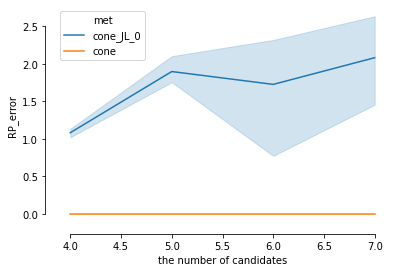

In [147]:
sns.lineplot(x="the number of candidates", y="RP_error",hue="met",data=df)
sns.despine(offset=10, trim=True)

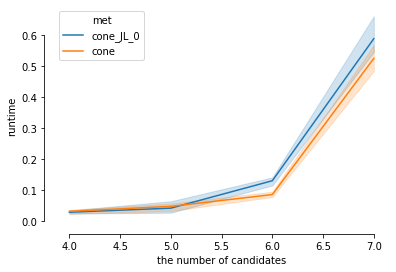

In [148]:
sns.lineplot(x="the number of candidates", y="runtime",hue="met",#style="event",  #palette=["m", "g",'y','r'],
            data=df[df["met"]!='MEV0']) #df[df["met"]!='MEV0']
sns.despine(offset=10, trim=True)

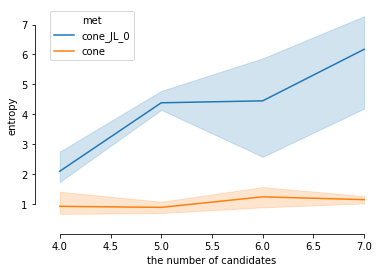

In [149]:
sns.lineplot(x="the number of candidates", y="entropy",hue="met",#style="event",  #palette=["m", "g",'y','r'],
            data=df) #df[df["met"]!='MEV0']
sns.despine(offset=10, trim=True)

In [150]:
sns.boxplot(x="the number of candidates", y="norm",hue="met", palette=["m", "g",'y','r'],
            data=df)
sns.despine(offset=10, trim=True)

ValueError: Could not interpret input 'norm'

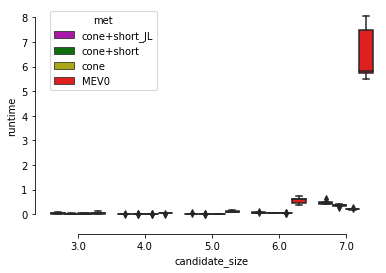

In [18]:
sns.boxplot(x="the number of candidates", y="runtime",hue="met", palette=["m", "g",'y','r'],
            data=df)
sns.despine(offset=10, trim=True)
# the number of candidates

In [34]:
for n in range(3,10):
    T=factorial(n)
    print(T)
    print(n*(n-1)/2)
    print(int(log(T)**2))
    print(int(log(T)**2.5))
    #print(int(1.5*log(T+1)))
    #print(int(sqrt(log(T+1))))
    print('\n')

6
3.0
3
4


24
6.0
10
18


120
10.0
22
50


720
15.0
43
111


5040
21.0
72
212


40320
28.0
112
366


362880
36.0
163
586




# Sorted Probabilities of All Orderings

In [57]:
print('runtime',r1,r2,r3)

runtime 0.030930042266845703 0.031149625778198242 0.028400421142578125


In [211]:
mev_fac(empirical,theoretical,91) # factorization

the status is: solsta.prim_infeas_cer
the runtime is: 0.019290924072265625
the size of the orderings set is 6
the number of negative values:  0 ; the number of 0:  6
The entropy of u is: 0
The Frobenius Norm of the difference is: 0.5438542001821823


In [212]:
mev_ent(empirical,theoretical,91) # entropy penalty

the status is: solsta.prim_infeas_cer
the runtime is: 0.025803089141845703
the size of the orderings set is 6
the number of negative values:  0 ; the number of 0:  6
The entropy of u is: 0
The Frobenius Norm of the difference is: 0.5438542001821823


# Low rank formulations

In [3]:
def mev_fac(empirical,theoretical,p):

    env  = mosek.Env()
    task = env.Task(0,0)
    inf = 10**2
    numvar = T
    #q=T-1 # the number of eigenvalues that we want to penalise
    barvardim = [T]*(p*2+1) # U, Y_1, Y_2, Z_1, Z_2   ( Z=Y-U+kI )

    # variables:
    task.appendbarvars(barvardim) 
    u = msk_newvar(task, T)
    eta = msk_newvar(task, 1)
    k = msk_newvar(task, p)
    sigma = msk_newvar(task, p+1)
    # we add sigma0 and sigma3 because the same variables cannot be used in two cones,

    # var bounds
    for i in range(T):
        task.putvarbound(u+i , mosek.boundkey.ra, 0, 1.0)
    for i in range(p):  
        task.putvarbound(sigma+i , mosek.boundkey.fx, 0,0)       
    task.putvarbound(sigma+p , mosek.boundkey.ra, 0, 1.0)
    task.putvarbound(eta , mosek.boundkey.ra, -inf, 0)

    # sum u_t = 1 ,or equivalently, tr U = 1
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(u,u+T)],[1]*T)
    task.putconbound(c,mosek.boundkey.fx,1,1)

    # u*S(t)=\hat(S)(V) 
    for i in range(1,n):
        for j in range(i):
            c = msk_newcon(task, 1)
            #task.putbarablocktriplet(T,[c]*T,[0]*T,[*range(T)], [*range(T)], [theoretical[k][i,j] for k in range(T)])
            task.putarow(c,[*range(u,u+T)],[theoretical[k][i,j] for k in range(T)])
            task.putconbound(c,mosek.boundkey.fx,empirical[i,j],empirical[i,j]) #,empirical[i,j]

    # (u_t,1,eta) \in Cone and u_t== u_{t,t}
    for t in range(T):
        # u_t = U_{t,t}
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [t], [t], [-1]  # Entries: (k,l)->v
            )
        task.putarow(c,[u+t],[1])
        task.putconbound(c,mosek.boundkey.fx,0,0) #==============================================
        msk_relent(task, eta, u+t, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u_{i,j}=0, i \neq j
    for i in range(1,T):
        for j in range(i):
            c = msk_newcon(task, 1)
            task.putbarablocktriplet(
                1,                             # Number of entries
                [c],                           # Which constraint (i = 1)
                [0],                           # Which SDP variable (j = 1)
                [i], [j], [1]  # Entries: (k,l)->v
                )
            task.putconbound(c,mosek.boundkey.fx,0,0)

    # 0<=sigma_1<=...<=sigma_p<=sigma_end/(T-p)
    for t in range(p-1):
        c = msk_newcon(task, 1)
        task.putarow(c,[sigma+t,sigma+t+1],[-1,1]) #  1>= sigma+t+1 - sigma+t >= 0
        task.putconbound(c,mosek.boundkey.ra,0,1)
    c = msk_newcon(task, 1)
    task.putarow(c,[sigma+p-1,sigma+p],[-1,1/(T-p)]) #1>= sigma_end /(T-p) - sigma_p >=0
    task.putconbound(c,mosek.boundkey.ra,0,1)

    # sigma_1+...+sigma_T = 1 (because tr U = 1)
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(sigma,sigma+p+1)],[1]*(p+1))
    task.putconbound(c,mosek.boundkey.fx,1.0,1.0)

    # Y - U + k I >= 0 (we set Z = Y - U + k I, because Z must be SDP)
    for r in range(p):
        for i in range(1,n):
            for j in range(i):
                c = msk_newcon(task, 1)
                # Y
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [1+r],                         # Which SDP variable (j = 1)
                    [i], [j], [1]  # Entries: (k,l)->v
                    )
                # U
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [0],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]  # Entries: (k,l)->v
                    )
                # Z
                task.putbarablocktriplet(
                    1,                               # Number of entries
                    [c],                             # Which constraint (i = 1)
                    [1+p+r],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]
                    )
                # k I
                if i == j:
                    task.putarow(c,[k+r],[1])
                task.putconbound(c,mosek.boundkey.fx,0,0)

    # sum(sigma) - r*k - tr Y >= 0
    for r in range(p):
        c = msk_newcon(task, 1)
        # tr Y
        task.putbarablocktriplet(
                T,                               # Number of entries
                [c]*T,                           # Which constraint (i = 1)
                [1+r]*T,                         # Which SDP variable (j = 1)
                [*range(T)], [*range(T)], [-1]*T  # Entries: (k,l)->v
                )
        task.putarow(c,[*range(sigma+p-r,sigma+p+1)],[1]*(r+1))
        task.putarow(c,[k+r],[-(r+1)])
        task.putconbound(c,mosek.boundkey.ra,0,inf)

    # objective
    # eta is the parameter for RE_|T|
    task.putclist([eta],[1]) 
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [76]:
def mev(empirical,theoretical,q):

    env  = mosek.Env()
    task = env.Task(0,0)
    inf = 10**2
    numvar = T
    #q=T-1 # the number of eigenvalues that we want to penalise
    barvardim = [T]*(q*2+1) # U, Y_1, Y_2, Z_1, Z_2   ( Z=Y-U+kI )

    # variables:
    task.appendbarvars(barvardim) 
    u = msk_newvar(task, T)
    eta = msk_newvar(task, 1)
    delta = msk_newvar(task,1)
    k = msk_newvar(task, q)
    sigma = msk_newvar(task, q+1)
    sigma0= msk_newvar(task, q) # sigma0 = sigma 
    varsigma= msk_newvar(task, q)
    sigma3= msk_newvar(task, q) # sigma3 = varsigma
    # we add sigma0 and sigma3 because the same variables cannot be used in two cones,

    # var bounds
    for i in range(T):
        task.putvarbound(u+i , mosek.boundkey.ra, 0, 1.0)
    for i in range(q):    
        task.putvarbound(sigma+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(sigma0+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(varsigma+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(sigma3+i , mosek.boundkey.ra, 0, 1.0)
    task.putvarbound(sigma+q , mosek.boundkey.ra, 0, 1.0)
    task.putvarbound(eta , mosek.boundkey.ra, -inf, 0)
    task.putvarbound(delta , mosek.boundkey.ra, -inf, 0) 

    # sum u_t = 1 ,or equivalently, tr U = 1
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(u,u+T)],[1]*T)
    task.putconbound(c,mosek.boundkey.fx,1,1)

    # u*S(t)=\hat(S)(V) 
    for i in range(1,n):
        for j in range(i):
            c = msk_newcon(task, 1)
            #task.putbarablocktriplet(T,[c]*T,[0]*T,[*range(T)], [*range(T)], [theoretical[k][i,j] for k in range(T)])
            task.putarow(c,[*range(u,u+T)],[theoretical[k][i,j] for k in range(T)])
            task.putconbound(c,mosek.boundkey.fx,empirical[i,j],empirical[i,j]) #,empirical[i,j]

    # (u_t,1,eta) \in Cone and u_t== u_{t,t}
    for t in range(T):
        # u_t = U_{t,t}
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [t], [t], [-1]  # Entries: (k,l)->v
            )
        task.putarow(c,[u+t],[1])
        task.putconbound(c,mosek.boundkey.fx,0,0) #==============================================
        msk_relent(task, eta+t, u+t, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u_{i,j}=0, i \neq j
    for i in range(1,T):
        for j in range(i):
            c = msk_newcon(task, 1)
            task.putbarablocktriplet(
                1,                             # Number of entries
                [c],                           # Which constraint (i = 1)
                [0],                           # Which SDP variable (j = 1)
                [i], [j], [1]  # Entries: (k,l)->v
                )
            task.putconbound(c,mosek.boundkey.fx,0,0)

    # (sigma0,sigma3,delta)\in Cone
    for t in range(q):
        c = msk_newcon(task,1)
        # (sigma0,sigma3,delta)\in Cone
        msk_relent(task, delta, sigma0+t, sigma3+t) #(t,x,y) t >= x * log(x/y), x,y>=0

    # 0<=sigma_1<=...<=sigma_q<=sigma_end/(T-q)
    for t in range(q-1):
        c = msk_newcon(task, 1)
        task.putarow(c,[sigma+t,sigma+t+1],[-1,1]) #  1>= sigma+t+1 - sigma+t >= 0
        task.putconbound(c,mosek.boundkey.ra,0,1)
    c = msk_newcon(task, 1)
    task.putarow(c,[sigma+q-1,sigma+q],[-1,1/(T-q)]) #1>= sigma_end /(T-q) - sigma_q >=0
    task.putconbound(c,mosek.boundkey.ra,0,1)

    # sigma3 == varsigma >= (sigma)^2, sigma == sigma0
    for t in range(q):
        c = msk_newcon(task, 2)
        task.putarow(c,[sigma+t,sigma0+t],[-1,1]) #sigma+t <= sigma+t+1 -> sigma+t+1 - sigma+t >= 0
        task.putconbound(c,mosek.boundkey.fx,0,0)
        task.putarow(c+1,[varsigma+t,sigma3+t],[-1,1]) #sigma+t <= sigma+t+1 -> sigma+t+1 - sigma+t >= 0
        task.putconbound(c+1,mosek.boundkey.fx,0,0)
        msk_sq(task, varsigma+t, sigma+t) # (task, t, x) t >= x^2

    # sigma_1+...+sigma_T = 1 (because tr U = 1)
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(sigma,sigma+q+1)],[1]*(q+1))
    task.putconbound(c,mosek.boundkey.fx,1.0,1.0)

    # Y - U + k I >= 0 (we set Z = Y - U + k I, because Z must be SDP)
    for r in range(q):
        for i in range(1,n):
            for j in range(i):
                c = msk_newcon(task, 1)
                # Y
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [1+r],                         # Which SDP variable (j = 1)
                    [i], [j], [1]  # Entries: (k,l)->v
                    )
                # U
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [0],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]  # Entries: (k,l)->v
                    )
                # Z
                task.putbarablocktriplet(
                    1,                               # Number of entries
                    [c],                             # Which constraint (i = 1)
                    [1+q+r],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]
                    )
                # k I
                if i == j:
                    task.putarow(c,[k+r],[1])
                task.putconbound(c,mosek.boundkey.fx,0,0)

    # sum(sigma) - r*k - tr Y >= 0
    for r in range(q):
        c = msk_newcon(task, 1)
        # tr Y
        task.putbarablocktriplet(
                T,                               # Number of entries
                [c]*T,                           # Which constraint (i = 1)
                [1+r]*T,                         # Which SDP variable (j = 1)
                [*range(T)], [*range(T)], [-1]*T  # Entries: (k,l)->v
                )
        task.putarow(c,[*range(sigma+q-r,sigma+q+1)],[1]*(r+1))
        task.putarow(c,[k+r],[-(r+1)])
        task.putconbound(c,mosek.boundkey.ra,0,inf)

    # objective
    # eta is the parameter for RE_|T|, delta is for RE_q. 
    task.putclist([eta,delta],[1,10]) # both need to be non negative.
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [75]:
def mev_ent(empirical,theoretical,q):

    env  = mosek.Env()
    task = env.Task(0,0)
    inf = 10**2
    numvar = T
    #q=T-1 # the number of eigenvalues that we want to penalise
    barvardim = [T]*(q*2+1) # U, Y_1, Y_2, Z_1, Z_2   ( Z=Y-U+kI )

    # variables:
    task.appendbarvars(barvardim) 
    u = msk_newvar(task, T)
    eta = msk_newvar(task, 1)
    delta = msk_newvar(task,1)
    k = msk_newvar(task, q)
    sigma = msk_newvar(task, q+1)
    sigma0= msk_newvar(task, q) # sigma0 = sigma 
    varsigma= msk_newvar(task, q)
    sigma3= msk_newvar(task, q) # sigma3 = varsigma
    # we add sigma0 and sigma3 because the same variables cannot be used in two cones,

    # var bounds
    for i in range(T):
        task.putvarbound(u+i , mosek.boundkey.ra, 0, 1.0)
    for i in range(q):    
        task.putvarbound(sigma+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(sigma0+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(varsigma+i , mosek.boundkey.ra, 0, 1.0)
        task.putvarbound(sigma3+i , mosek.boundkey.ra, 0, 1.0)
    task.putvarbound(sigma+q , mosek.boundkey.ra, 0.5, 1.0)
    task.putvarbound(eta , mosek.boundkey.ra, -inf, 0)
    task.putvarbound(delta , mosek.boundkey.ra, -inf, 0) 

    # sum u_t = 1 ,or equivalently, tr U = 1
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(u,u+T)],[1]*T)
    task.putconbound(c,mosek.boundkey.fx,1,1)

    # u*S(t)=\hat(S)(V) 
    for i in range(1,n):
        for j in range(i):
            c = msk_newcon(task, 1)
            #task.putbarablocktriplet(T,[c]*T,[0]*T,[*range(T)], [*range(T)], [theoretical[k][i,j] for k in range(T)])
            task.putarow(c,[*range(u,u+T)],[theoretical[k][i,j] for k in range(T)])
            task.putconbound(c,mosek.boundkey.fx,empirical[i,j],empirical[i,j]) #,empirical[i,j]

    # (u_t,1,eta) \in Cone and u_t== u_{t,t}
    for t in range(T):
        # u_t = U_{t,t}
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [t], [t], [-1]  # Entries: (k,l)->v
            )
        task.putarow(c,[u+t],[1])
        task.putconbound(c,mosek.boundkey.fx,0,0) #==============================================
        msk_relent(task, eta, u+t, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u_{i,j}=0, i \neq j
    for i in range(1,T):
        for j in range(i):
            c = msk_newcon(task, 1)
            task.putbarablocktriplet(
                1,                             # Number of entries
                [c],                           # Which constraint (i = 1)
                [0],                           # Which SDP variable (j = 1)
                [i], [j], [1]  # Entries: (k,l)->v
                )
            task.putconbound(c,mosek.boundkey.fx,0,0)

    # (sigma0,sigma3,delta)\in Cone
    for t in range(q):
        c = msk_newcon(task,1)
        # (sigma0,sigma3,delta)\in Cone
        msk_relent(task, delta, sigma0+t, sigma3+t) #(t,x,y) t >= x * log(x/y), x,y>=0

    # 0<=sigma_1<=...<=sigma_q<=sigma_end/(T-q)
    for t in range(q-1):
        c = msk_newcon(task, 1)
        task.putarow(c,[sigma+t,sigma+t+1],[-1,1]) #  1>= sigma+t+1 - sigma+t >= 0
        task.putconbound(c,mosek.boundkey.ra,0,1)
    c = msk_newcon(task, 1)
    task.putarow(c,[sigma+q-1,sigma+q],[-1,1/(T-q)]) #1>= sigma_end /(T-q) - sigma_q >=0
    task.putconbound(c,mosek.boundkey.ra,0,1)

    # sigma3 == varsigma >= (sigma)^2, sigma == sigma0
    for t in range(q):
        c = msk_newcon(task, 2)
        task.putarow(c,[sigma+t,sigma0+t],[-1,1]) #sigma+t <= sigma+t+1 -> sigma+t+1 - sigma+t >= 0
        task.putconbound(c,mosek.boundkey.fx,0,0)
        task.putarow(c+1,[varsigma+t,sigma3+t],[-1,1]) #sigma+t <= sigma+t+1 -> sigma+t+1 - sigma+t >= 0
        task.putconbound(c+1,mosek.boundkey.fx,0,0)
        msk_sq(task, varsigma+t, sigma+t) # (task, t, x) t >= x^2

    # sigma_1+...+sigma_T = 1 (because tr U = 1)
    c = msk_newcon(task, 1)
    task.putarow(c,[*range(sigma,sigma+q+1)],[1]*(q+1))
    task.putconbound(c,mosek.boundkey.fx,1.0,1.0)

    # Y - U + k I >= 0 (we set Z = Y - U + k I, because Z must be SDP)
    for r in range(q):
        for i in range(1,n):
            for j in range(i):
                c = msk_newcon(task, 1)
                # Y
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [1+r],                         # Which SDP variable (j = 1)
                    [i], [j], [1]  # Entries: (k,l)->v
                    )
                # U
                task.putbarablocktriplet(
                    1,                             # Number of entries
                    [c],                           # Which constraint (i = 1)
                    [0],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]  # Entries: (k,l)->v
                    )
                # Z
                task.putbarablocktriplet(
                    1,                               # Number of entries
                    [c],                             # Which constraint (i = 1)
                    [1+q+r],                           # Which SDP variable (j = 1)
                    [i], [j], [-1]
                    )
                # k I
                if i == j:
                    task.putarow(c,[k+r],[1])
                task.putconbound(c,mosek.boundkey.fx,0,0)

    # sum(sigma) - r*k - tr Y >= 0
    for r in range(q):
        c = msk_newcon(task, 1)
        # tr Y
        task.putbarablocktriplet(
                T,                               # Number of entries
                [c]*T,                           # Which constraint (i = 1)
                [1+r]*T,                         # Which SDP variable (j = 1)
                [*range(T)], [*range(T)], [-1]*T  # Entries: (k,l)->v
                )
        task.putarow(c,[*range(sigma+q-r,sigma+q+1)],[1]*(r+1))
        task.putarow(c,[k+r],[-(r+1)])
        task.putconbound(c,mosek.boundkey.ra,0,inf)

    # objective
    # eta is the parameter for RE_|T|, delta is for RE_q. 
    task.putclist([eta,delta],[1,10]) # both need to be non negative.
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

# Original MEV with SDP variable

In [5]:
def rowreduce_gaussian(T,theoretical,empirical):
    b_tem=matrix2vector(empirical)
    A_tem=matrix2vector(theoretical[0])
    for k in range(1,T):
        A_tem=np.concatenate((A_tem,matrix2vector(theoretical[k])),axis=1)

    B_tem=Matrix(np.concatenate((A_tem,b_tem),axis=1))
    B=B_tem.echelon_form()
    B=np.array(B).astype(np.float64)
    #print(B)
    RB=np.linalg.matrix_rank(B)
    #print(RB)
    A=B[0:RB,0:-1]
    b=B[0:RB,T:T+1]
    return A,b


In [6]:
def mev_new_long_gaussian(empirical,theoretical):
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    #b=matrix2vector_long(empirical)
    #A=matrix2vector_long(theoretical[0])
    #for k in range(1,T):
    #    A=np.concatenate((A,matrix2vector_long(theoretical[k])),axis=1)
    A,b=rowreduce_gaussian(T,theoretical,empirical)
    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),A[row,:])
        task.putconbound(c, mosek.boundkey.fx, b[row], b[row])   
            
    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)
    
    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

In [ ]:
### MEV ==================================================================

env  = mosek.Env()
task = env.Task(0,0)
inf = 100
numvar = T
barvardim = [n]

# variables -------------------------------------------------------------

# t is the entropy of u
t = msk_newvar(task, numvar)
u = msk_newvar(task, numvar)
task.appendbarvars(barvardim)

# constraints ------------------------------------------------------------

# 0<u<1 
for i in range(u,u+T):
    task.putvarbound(i, mosek.boundkey.ra, 0, 1)

# sum(u)=1
c = msk_newcon(task, 1)
task.putarow(c, range(u,u+T),[1.0]*T)
#task.putaij(c, 1, 1.0)
task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    
    
# u*theoretical=empirical
for i in range(n):
    for j in range(i):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),[theoretical[k][i,j] for k in range(T)])
        task.putconbound(c, mosek.boundkey.fx, empirical[i,j], empirical[i,j])
        
# u*theoretical=X
for i in range(n):
    for j in range(i):
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [i], [j], [0.5]                # Entries: (k,l)->v
            )
        task.putarow(c,range(u, u+T),[-theoretical[k][i,j] for k in range(T)])
task.putconboundlist([*range(int(c-(n-1)*n/2)+1,c+1)], [mosek.boundkey.fx]*int((n-1)*n/2),
        [0]*int((n-1)*n/2),[0]*int((n-1)*n/2))
        
# t >= u * log(u), u>=0  #i.e., -t <= -u * log(u) --> max -t --> min t
for i in range(T):
    task.appendcone(mosek.conetype.pexp, 0.0, [msk_newvar_fx(task, 1, 1.0), u+i, t+i])
    # -y ln(y/x) > z    
    
# objective ----------------------------------------------------------------
task.putclist(range(t,t+T), [1.0]*T)
#task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

# Input the objective sense (minimize/maximize)
task.putobjsense(mosek.objsense.maximize)

# Solve the problem and print summary
task.optimize()

# Get status information about the solution
prosta = task.getprosta(mosek.soltype.itr)
solsta = task.getsolsta(mosek.soltype.itr)

if (solsta == mosek.solsta.optimal):
    print("Optimal solution")
else:
    print("Other solution status")

# solution
xx = [0.0] * task.getnumvar()
task.getxx(mosek.soltype.itr,xx)
print(xx[T:2*T])

lenbarvar = barvardim[0] * (barvardim[0] + 1) / 2
barx = [0.] * int(lenbarvar)
task.getbarxj(mosek.soltype.itr, 0, barx)
barxx=np.zeros((n,n))
tem=0
for i in range(n):
    for j in range(i,n):
        barxx[i,j]=barx[tem]
        barxx[j,i]=barx[tem]
        tem+=1
print(barxx)

print(task.getprimalobj(mosek.soltype.itr))

In [ ]:
### MEV ==================================================================

env  = mosek.Env()
task = env.Task(0,0)
inf = 100
numvar = T
barvardim = [n]

# variables -------------------------------------------------------------

# t is the entropy of u
t = msk_newvar(task, numvar)
u = msk_newvar(task, numvar)
task.appendbarvars(barvardim)

# constraints ------------------------------------------------------------

# 0<u<1 
for i in range(u,u+T):
    task.putvarbound(i, mosek.boundkey.ra, 0, 1)

# sum(u)=1
c = msk_newcon(task, 1)
task.putarow(c, range(u,u+T),[1.0]*T)
#task.putaij(c, 1, 1.0)
task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

# t >= u * log(u), u>=0  #i.e., -t <= -u * log(u) --> max -t --> min t
for i in range(T):
    task.appendcone(mosek.conetype.pexp, 0.0, [msk_newvar_fx(task, 1, 1.0), u+i, t+i])
    # -y ln(y/x) > z
    
# X=empirical
for i in range(n):
    for j in range(i):
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [i], [j], [0.5])                 # Entries: (k,l)->v
        task.putconbound(c, mosek.boundkey.fx, empirical[i,j], empirical[i,j])
        
# X=u*theoretical
for i in range(n):
    for j in range(i):
        c = msk_newcon(task, 1)
        task.putbarablocktriplet(
            1,                             # Number of entries
            [c],                           # Which constraint (i = 1)
            [0],                           # Which SDP variable (j = 1)
            [i], [j], [0.5])                 # Entries: (k,l)->v
        task.putarow(c,range(u, u+T),[-theoretical[k][i,j] for k in range(T)])
task.putconboundlist([*range(int(c-(n-1)*n/2)+1,c+1)], [mosek.boundkey.fx]*int((n-1)*n/2),
    [-0]*int((n-1)*n/2),[0]*int((n-1)*n/2)) 
        
# objective ----------------------------------------------------------------
task.putclist(range(t, t+T), [1.0]*T)
#task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

# Input the objective sense (minimize/maximize)
task.putobjsense(mosek.objsense.maximize)

# Solve the problem and print summary
task.optimize()

# Get status information about the solution
prosta = task.getprosta(mosek.soltype.itr)
solsta = task.getsolsta(mosek.soltype.itr)

if (solsta == mosek.solsta.optimal):
    print("Optimal solution")
else:
    print("Other solution status")

# solution
xx = [0.0] * task.getnumvar()
task.getxx(mosek.soltype.itr,xx)
print(xx[T:2*T])

lenbarvar = barvardim[0] * (barvardim[0] + 1) / 2
barx = [0.] * int(lenbarvar)
task.getbarxj(mosek.soltype.itr, 0, barx)
barxx=np.zeros((n,n))
tem=0
for i in range(n):
    for j in range(i,n):
        barxx[i,j]=barx[tem]
        barxx[j,i]=barx[tem]
        tem+=1
print(barxx)

print(task.getprimalobj(mosek.soltype.itr))

# Original MEV without SDP variable

In [ ]:
"""
# u*theoretical=empirical
c = msk_newcon(task, 1)
task.putarow(c, range(u, u+T),[syma0,syma1,syma2,syma3,syma4,syma5])
#task.putaij(c, symc, -1.0)
task.putconbound(c, mosek.boundkey.fx, symc, symc)

# sum(u)=1
c = msk_newcon(task, 1)
task.putarow(c, range(u, u+T),[1.0]*T)
#task.putaij(c, 1, 1.0)
task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)

# t >= u * log(u), u>=0  #i.e., -t <= -u * log(u) --> max -t --> min t
for i in range(T):
    task.appendcone(mosek.conetype.pexp, 0.0, [msk_newvar_fx(task, 1, 1.0), u+i, t+i])
    # -y ln(y/x) > z
    
task.putclist(range(t, t+T), [1.0]*T)

task.appendbarvars(BARVARDIM)

task.putbarcj(0, [symc], [1.0])
task.putbaraij(0, 0, [syma0], [1.0])
task.putbaraij(1, 0, [syma1], [1.0])
"""
### MEV ==================================================================

env  = mosek.Env()
task = env.Task(0,0)
inf = 100
numvar = T

# variables -------------------------------------------------------------
# t is the entropy of u
t = msk_newvar(task, numvar)
u = msk_newvar(task, numvar)

# constraints ------------------------------------------------------------

# 0<u<1 
for i in range(u,u+T):
    task.putvarbound(i, mosek.boundkey.ra, 0, 1)

# sum(u)=1
c = msk_newcon(task, 1)
task.putarow(c, range(u,u+T),[1.0]*T)
#task.putaij(c, 1, 1.0)
task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

# t >= u * log(u), u>=0  #i.e., -t <= -u * log(u) --> max -t --> min t
for i in range(T):
    task.appendcone(mosek.conetype.pexp, 0.0, [msk_newvar_fx(task, 1, 1.0), u+i, t+i])
    # -y ln(y/x) > z
    
# u*theoretical=empirical
for i in range(n):
    for j in range(i+1):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),[theoretical[k][i,j] for k in range(T)])
        task.putconbound(c, mosek.boundkey.fx, empirical[i,j], empirical[i,j])

# objective ----------------------------------------------------------------
task.putclist(range(t, t+T), [1.0]*T)
#task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

# Input the objective sense (minimize/maximize)
task.putobjsense(mosek.objsense.maximize)

# Solve the problem and print summary
task.optimize()

# Get status information about the solution
prosta = task.getprosta(mosek.soltype.itr)
solsta = task.getsolsta(mosek.soltype.itr)

if (solsta == mosek.solsta.optimal):
    print("Optimal solution")
else:
    print("Other solution status")

task.solutionsummary(mosek.streamtype.log)
xx = [0.0] * task.getnumvar()
task.getxx(mosek.soltype.itr,xx)
print(xx[T:2*T])
print(task.getprimalobj(mosek.soltype.itr))

# end

In [247]:
def mev_org_remove(empirical,theoretical):
    X=[]
    T_tem=int(T/n)
    runtime=0
    for c in range(n):
        emp_tem=np.delete(empirical, c, 0)
        emp_tem=np.delete(emp_tem, c, 1)
        the_tem={}
        for k in range(T_tem):
            the_tem[k]=np.delete(theoretical[c*T_tem+k], c, 0)
            the_tem[k]=np.delete(the_tem[k], c, 1)

        b=matrix2vector_long(emp_tem)
        A=matrix2vector_long(the_tem[0])
        for k in range(1,T_tem):
            A=np.concatenate((A,matrix2vector_long(the_tem[k])),axis=1)

        ### MEV ==================================================================

        env  = mosek.Env()
        task = env.Task(0,0)

        # variables -------------------------------------------------------------
        # t is the entropy of u
        eta = msk_newvar(task, T_tem)
        u = msk_newvar(task, T_tem)

        # constraints ------------------------------------------------------------

        # 0<u<1 
        for i in range(T_tem):
            task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
            task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

        # sum(u)=1
        c = msk_newcon(task, 1)
        task.putarow(c, range(u,u+T_tem),[1.0]*T_tem)
        #task.putaij(c, 1, 1.0)
        task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

        # max entropy
        for i in range(T_tem):
            msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

        for row in range(A.shape[0]):
            c = msk_newcon(task, 1)
            task.putarow(c, range(u, u+T_tem),A[row,:])
            task.putconbound(c, mosek.boundkey.fx, b[row], b[row])     

        # objective ----------------------------------------------------------------
        task.putclist(range(eta,eta+T_tem),[1]*T_tem)
        #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

        # Input the objective sense (minimize/maximize)
        task.putobjsense(mosek.objsense.minimize)

        # Solve the problem and print summary
        starttime = time.time()
        task.optimize()
        endtime = time.time()

        # get solution of the diagonal (equal to the SDP var)
        xx = [0.0] * task.getnumvar()
        task.getxx(mosek.soltype.itr,xx)

        X+=xx
        runtime+=endtime-starttime

    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    eta = msk_newvar(task, T)
    u = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    lis=[*range(T)]
    for i in range(T):
        if X[i]==0:
            lis.remove(i)
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)   
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)
    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    #task.putaij(c, 1, 1.0)
    task.putconbound(c, mosek.boundkey.fx, n, n)

    # u_1=u_2=...u_n
    for j in range(n):
        for i in range(T_tem-1):
            c = msk_newcon(task, 1)
            task.putarow(c, range(u+i+j*n,u+i+2+j*n),[1,-1])
            task.putconbound(c, mosek.boundkey.fx, 0, 0)

    # max entropy
    #list=[[u+i]*T_tem for i in range(n)]
    #flat_list = [item for sublist in list for item in sublist]
    for i in lis:
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1/X[i])) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    b=matrix2vector_long(empirical)
    A=matrix2vector_long(theoretical[0])
    for k in range(1,T):
        A=np.concatenate((A,matrix2vector_long(theoretical[k])),axis=1)
    for row in range(A.shape[0]):
        c = msk_newcon(task, 1)
        task.putarow(c,range(u,u+T), A[row,:])
        task.putconbound(c, mosek.boundkey.fx, b[row], b[row])  

    # objective ------------------------------------------------------
    task.putclist([eta+i for i in lis],[1/X[i] for i in lis])
    #task.putclist(range(task.getnumvar()),[1.0]*task.getnumvar())

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()
    runtime+=endtime-starttime

    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    Y=[X[i]*xx[i] for i in range(T)]

    report(Y,0,task.getsolsta(mosek.soltype.itr),runtime)
    assess(Y)
    return runtime

In [ ]:
import sys
import mosek

# Since the value of infinity is ignored, we define it solely
# for symbolic purposes
inf = 0.0

# Define a stream printer to grab output from MOSEK
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()


def main():
    # Make mosek environment
    with mosek.Env() as env:

        # Create a task object and attach log stream printer
        with env.Task(0, 0) as task:
            task.set_Stream(mosek.streamtype.log, streamprinter)

            # Bound keys for constraints
            bkc = [mosek.boundkey.fx,
                   mosek.boundkey.fx]

            # Bound values for constraints
            blc = [1.0, 0.5]
            buc = [1.0, 0.5]

            # Below is the sparse representation of the A
            # matrix stored by row.
            asub = [[0],
                    [1, 2]]
            aval = [[1.0],
                    [1.0, 1.0]]

            conesub = [0, 1, 2]

            barci = [0, 1, 1, 2, 2]
            barcj = [0, 0, 1, 1, 2]
            barcval = [2.0, 1.0, 2.0, 1.0, 2.0]

            barai = [[0, 1, 2],
                     [0, 1, 2, 1, 2, 2]]
            baraj = [[0, 1, 2],
                     [0, 0, 0, 1, 1, 2]]
            baraval = [[1.0, 1.0, 1.0],
                       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

            numvar = 3
            numcon = len(bkc)
            BARVARDIM = [3]

            # Append 'numvar' variables.
            # The variables will initially be fixed at zero (x=0).
            task.appendvars(numvar)

            # Append 'numcon' empty constraints.
            # The constraints will initially have no bounds.
            task.appendcons(numcon)

            # Append matrix variables of sizes in 'BARVARDIM'.
            # The variables will initially be fixed at zero.
            task.appendbarvars(BARVARDIM)

            # Set the linear term c_0 in the objective.
            task.putcj(0, 1.0)

            for j in range(numvar):
                # Set the bounds on variable j
                # blx[j] <= x_j <= bux[j]
                task.putvarbound(j, mosek.boundkey.fr, -inf, +inf)

            for i in range(numcon):
                # Set the bounds on constraints.
                # blc[i] <= constraint_i <= buc[i]
                task.putconbound(i, bkc[i], blc[i], buc[i])

                # Input row i of A
                task.putarow(i,                  # Constraint (row) index.
                             asub[i],            # Column index of non-zeros in constraint i.
                             aval[i])            # Non-zero values of row i.

            # Add the quadratic cone constraint
            task.appendcone(mosek.conetype.quad,
                            0.0,
                            conesub)

            symc = task.appendsparsesymmat(BARVARDIM[0],
                                           barci,
                                           barcj,
                                           barcval)

            syma0 = task.appendsparsesymmat(BARVARDIM[0],
                                            barai[0],
                                            baraj[0],
                                            baraval[0])

            syma1 = task.appendsparsesymmat(BARVARDIM[0],
                                            barai[1],
                                            baraj[1],
                                            baraval[1])

            task.putbarcj(0, [symc], [1.0])

            task.putbaraij(0, 0, [syma0], [1.0])
            task.putbaraij(1, 0, [syma1], [1.0])

            # Input the objective sense (minimize/maximize)
            task.putobjsense(mosek.objsense.minimize)

            print(syma0)
                

# call the main function
try:
    main()
except mosek.MosekException as e:
    print("ERROR: %s" % str(e.errno))
    if e.msg is not None:
        print("\t%s" % e.msg)
        sys.exit(1)
except:
    import traceback
    traceback.print_exc()
    sys.exit(1)

In [ ]:
task=mosek.Env().Task(0,0)
inf = 0.0

# Bound keys for constraints
bkc = [mosek.boundkey.fx,
       mosek.boundkey.fx]

# Bound values for constraints
blc = [1.0, 0.5]
buc = [1.0, 0.5]

# Below is the sparse representation of the A
# matrix stored by row.
asub = [[0],
        [1, 2]]
aval = [[1.0],
        [1.0, 1.0]]

conesub = [0, 1, 2]

barci = [0, 1, 1, 2, 2]
barcj = [0, 0, 1, 1, 2]
barcval = [2.0, 1.0, 2.0, 1.0, 2.0]

numvar = 3
numcon = len(bkc)
BARVARDIM = [3]

# Append 'numvar' variables.
# The variables will initially be fixed at zero (x=0).
task.appendvars(numvar)

# Append 'numcon' empty constraints.
# The constraints will initially have no bounds.
task.appendcons(numcon)

# Append matrix variables of sizes in 'BARVARDIM'.
# The variables will initially be fixed at zero.
task.appendbarvars(BARVARDIM)

# Set the linear term c_0 in the objective.
task.putcj(0, 1.0)

for j in range(numvar):
    # Set the bounds on variable j
    # blx[j] <= x_j <= bux[j]
    task.putvarbound(j, mosek.boundkey.fr, -inf, +inf)

for i in range(numcon):
    # Set the bounds on constraints.
    # blc[i] <= constraint_i <= buc[i]
    task.putconbound(i, bkc[i], blc[i], buc[i])

    # Input row i of A
    task.putarow(i,                  # Constraint (row) index.
                 asub[i],            # Column index of non-zeros in constraint i.
                 aval[i])            # Non-zero values of row i.

# Add the quadratic cone constraint
task.appendcone(mosek.conetype.quad,
                0.0,
                conesub)

symc = task.appendsparsesymmat(BARVARDIM[0],
                               barci,
                               barcj,
                               barcval)

syma0 = task.appendsparsesymmat(BARVARDIM[0],
                                barai[0],
                                baraj[0],
                                baraval[0])

syma1 = task.appendsparsesymmat(BARVARDIM[0],
                                barai[1],
                                baraj[1],
                                baraval[1])

task.putbaraij(0, 0, [syma0], [1.0])

"""
task.putbarcj(0, [symc], [1.0])

task.putbaraij(0, 0, [syma0], [1.0])
task.putbaraij(1, 0, [syma1], [1.0])

# Input the objective sense (minimize/maximize)
task.putobjsense(mosek.objsense.minimize)

# Solve the problem and print summary
task.optimize()


task.appendcons(numcon)

task.putbaraij(0, 0, [syma0,syma1,syma2,syma3,syma4,syma5], [1.0]*6)
#[syma0,syma1,syma2,syma3,syma4,syma5]

task.putbarcj(0, [symc], [-1.0])
"""

In [ ]:
# call the main function
try:
    main()
except mosek.MosekException as e:
    print("ERROR: %s" % str(e.code))
    if msg is not None:
        print("\t%s" % e.msg)
        sys.exit(1)
except:
    import traceback
    traceback.print_exc()
    sys.exit(1)